<a href="https://colab.research.google.com/github/sergi-andreu/NLP-adapters/blob/main/TransformerAdapterChallenge_SergiAndreu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup
Do not edit these lines, but execute them to set up your development environment.

You can install additional libraries using the same `pip` pattern as seen in the cells below

In [ ]:
!pip install "squirrel-core[torch]"
!pip install "squirrel-datasets-core[torchvision]"

!pip install gdown
!gdown --folder https://drive.google.com/drive/folders/1pziYQZt5xAVhuTQv00CHIiqFDDP0VYqf?usp=sharing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Retrieving folder list
Processing file 1qYbnd4D2AYS6tRD9cCaGAPPINGr8rrX7 ted_test1_en-cs.raw.cs
Processing file 1tS_Xdlj0svPtLmt7XUI4jdF9ORlv-yfs ted_test1_en-cs.raw.en
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1qYbnd4D2AYS6tRD9cCaGAPPINGr8rrX7
To: /content/Adapter-Onsite-Challenge/ted_test1_en-cs.raw.cs
100% 174k/174k [00:00<00:00, 90.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tS_Xdlj0svPtLmt7XUI4jdF9ORlv-yfs
To: /content/Adapter-Onsite-Challenge/ted_test1_en-cs.raw.en
100% 171k/171k [00:00<00:00, 92.5MB/s]
Download completed


In [ ]:
from typing import List, Dict, Tuple, Any
from collections import defaultdict
import more_itertools
from pprint import pprint

import torch

from squirrel.iterstream.source import IterableSource
from squirrel_datasets_core.driver.huggingface import HuggingfaceDriver

#Dataset based on Squirrel

These are just some basic functions to help you get started with the Squirrel data-loading library. You can either modify the code here or use this as a starting point and add the transformations you need using the iterstream API.

We provide a small example on how the data looks like below.

In [ ]:
#@title
dataset_files = {
    'en': "./Adapter-Onsite-Challenge/ted_test1_en-cs.raw.en",
    'cs': "./Adapter-Onsite-Challenge/ted_test1_en-cs.raw.cs"
    #'en': "./ted_test1_en-cs.raw.en",
    #'cs': "./ted_test1_en-cs.raw.cs"
}

def get_mttt_iterable(iso, num_samples) -> IterableSource:
    """
    Returns an iterable over the MTTT TED dataset.

    iso: string indicating the language ISO. Either `cs` or `en`
    num_samples: int defining the number of samples to load into the dataset
    """
    with open(dataset_files[iso]) as fh:
        lines = [line.strip() for line in fh.readlines()[:num_samples]]

    eval_dataset = IterableSource(lines)
    return eval_dataset

import random

"""
def get_mttt_iterable_both(num_samples, shuffle=True) -> IterableSource:
  
    #Returns an iterable over the MTTT TED dataset. Returns both CS and EN (better for shuffling purposes)
    #num_samples: int defining the number of samples to load into the dataset

    index_shuf = list(range(1982))
    if shuffle: random.shuffle(index_shuf)

    print(index_shuf)

    with open(dataset_files["cs"]) as fh:
        print(len(fh.readlines()))
        lines = [fh.readlines()[i].strip() for i in index_shuf[:num_samples]]
    eval_dataset_cs = IterableSource(lines)
    
    with open(dataset_files["en"]) as fh:
        lines = [fh.readlines()[i].strip() for i in index_shuf[:num_samples]]
    eval_dataset_en = IterableSource(lines)

    return eval_dataset_cs, eval_dataset_en
"""

def get_wmt19_hf_iterable(split = 'validation') -> IterableSource:
    """
    Returns an iterable over the WMT'19 dataset. More specifically the CS <> EN subset

    """
    dataset = HuggingfaceDriver(name='wmt19', subset='cs-en', streaming=True).get_iter(split=split)
    return dataset


In [ ]:
#@title
wmt19_example = (get_wmt19_hf_iterable()
                  .take(5)
                  .collect())


mttt_example = (get_mttt_iterable('en', 20)
                  .take(5)
                  .collect())

mttt_example_cs = (get_mttt_iterable('cs', 20)
                  .take(5)
                  .collect())

"""
print(get_mttt_iterable_both(20))
mttt_example_both = (get_mttt_iterable_both(20)
                  .take(5)
                  .collect())
"""

pprint(wmt19_example)
pprint(mttt_example)
pprint(mttt_example_cs)

[{'translation': {'cs': 'Hnutí za občanská práva vydalo cestovní výstrahu pro '
                        'Missouri',
                  'en': 'Civil rights group issues travel warning for '
                        'Missouri'}},
 {'translation': {'cs': 'Národní asociace pro zvýhodňování barevných lidí '
                        '(NAACP) zveřejnila varování pro barevné lidi '
                        'cestující do Missouri na základě diskriminačních '
                        'zásad státu a rasistických útoků.',
                  'en': 'The National Association for the Advancement of '
                        'Colored People has put out an alert for people of '
                        "color traveling to Missouri because of the state's "
                        'discriminatory policies and racist attacks.'}},
 {'translation': {'cs': '„Cestovní doporučení NAACP pro stát Missouri, s '
                        'účinností od 28. srpna 2017, vyzývá afroamerické '
                        'cestující,

# Your implementation

In [ ]:
!pip install transformers
!pip install tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import utilities from transformers. Including the ones in modeling_bert, which we would use to define and create the adapters
from transformers import BertConfig, BertTokenizer, pipeline, DataCollatorWithPadding
from transformers.models.bert.modeling_bert import  BertIntermediate, BertOutput, BertLayer, BertEncoder, BertModel, BertForSequenceClassification 
#from transformers import GPT2Model, GPT2Config, GPT2Tokenizer # Not used (I tried different models at the beggining)
#from transformers import OpenAIGPTConfig, OpenAIGPTModel, OpenAIGPTTokenizer # Not used (I tried different models at the beggining)

import numpy as np # always needed

## Define a function plotting the PCA projection of the embeddings

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import sklearn.decomposition as dc

MSELoss = torch.nn.MSELoss(reduction="mean")
MSELoss_unreduced = torch.nn.MSELoss(reduction="none")
CosSim = torch.nn.CosineSimilarity()

def plot_PCA_embeddings(tensor_plot, model, standardize=True, plot_segments=True, trained_pca = "none", return_pca = False, pooling=True, title="none", save="NONE"):

  encoded_cs, encoded_en = tensor_plot

  encoded_cs = tokenizer(cs_tensor, padding="max_length", truncation=True, return_tensors="pt").to(device)
  encoded_en = tokenizer(en_tensor, padding="max_length", truncation=True, return_tensors="pt").to(device)

  with torch.no_grad():
    model_output_cs = model(**encoded_cs)
    model_output_en = model(**encoded_en)

  if pooling:
      cs_embeddings = mean_pooling(model_output_cs, encoded_cs['attention_mask'])
      en_embeddings = mean_pooling(model_output_en, encoded_en['attention_mask'])

  else:
      cs_embeddings = model_output_cs[0]
      en_embeddings = model_output_en[0]

  cpu_cs = torch.flatten(cs_embeddings.cpu(), start_dim=1)
  cpu_en = torch.flatten(en_embeddings.cpu(), start_dim=1)

  if standardize:
    means_cs = cpu_cs.mean(dim=0, keepdim=True)
    stds_cs = cpu_cs.std(dim=0, keepdim=True)
    cpu_cs = (cpu_cs - means_cs) / stds_cs

    means_en = cpu_en.mean(dim=0, keepdim=True)
    stds_en = cpu_en.std(dim=0, keepdim=True)
    cpu_en = (cpu_en - means_en) / stds_en

  all = torch.cat((cpu_cs, cpu_en), 0)

  if trained_pca != "none": 
    pca = trained_pca
  else:
    PCA = dc.PCA
    pca = PCA(n_components=2)
    pca.fit(all)

  X_cs = np.transpose(pca.transform(cpu_cs))
  X_en = np.transpose(pca.transform(cpu_en))

  lines = [[(X_cs[0][i], X_cs[1][i]), (X_en[0][i], X_en[1][i])] for i in range(np.shape(X_cs)[1])]
  lc = mc.LineCollection(lines, colors="r", alpha=0.3)

  fig, ax = plt.subplots(figsize=(5,5))
  ax.scatter(X_cs[0], X_cs[1], c="b", label="Czech")
  ax.scatter(X_en[0], X_en[1], c="y", label="English")
  ax.set_xlabel("Component 1")
  ax.set_ylabel("Component 2")
  ax.set_aspect("equal", adjustable="box")
  ax.axis("square")

  if plot_segments:
    ax.add_collection(lc)

  ax.legend()
  if title == "none":
    ax.set_title("PCA projection")
  else:
    ax.set_title(title)  
  if save != "NONE":
    plt.savefig(save + ".jpg")

  plt.show()

  if return_pca: return pca


### Define a function plotting a "confusion matrix" (representing similarity metrics between sentences)

In [ ]:
import seaborn as sn # for plotting


def plot_confusion_matrix(tensor_plot, model, standardize=True, loss_type="CosSim", pooling=True, title="none", save="NONE"):
  encoded_cs, encoded_en = tensor_plot

  encoded_cs = tokenizer(cs_tensor, padding="max_length", truncation=True, return_tensors="pt").to(device)
  encoded_en = tokenizer(en_tensor, padding="max_length", truncation=True, return_tensors="pt").to(device)

  with torch.no_grad():
    model_output_cs = model(**encoded_cs)
    model_output_en = model(**encoded_en)

  if pooling:
      cs_embeddings = mean_pooling(model_output_cs, encoded_cs['attention_mask'])
      en_embeddings = mean_pooling(model_output_en, encoded_en['attention_mask'])

  else:
      cs_embeddings = model_output_cs[0]
      en_embeddings = model_output_en[0]

  cpu_cs = torch.flatten(cs_embeddings.cpu(), start_dim=1)
  cpu_en = torch.flatten(en_embeddings.cpu(), start_dim=1)

  if standardize:
    means_cs = cpu_cs.mean(dim=0, keepdim=True)
    stds_cs = cpu_cs.std(dim=0, keepdim=True)
    cpu_cs = (cpu_cs - means_cs) / stds_cs

    means_en = cpu_en.mean(dim=0, keepdim=True)
    stds_en = cpu_en.std(dim=0, keepdim=True)
    cpu_en = (cpu_en - means_en) / stds_en

  CM = []

  if loss_type == "CosSim":
    for embedding in cpu_cs:
      dummy_cs = CosSim(embedding.unsqueeze(0), cpu_en).cpu().numpy()
      CM.append(dummy_cs)

  if loss_type == "MSE":
    for embedding in cpu_cs:
      dummy_mse = torch.mean(MSELoss_unreduced(cpu_en, embedding.unsqueeze(0)), dim=1).cpu().numpy()
      CM.append(dummy_mse)

  CM = np.array(CM)
  print(np.shape(CM))

  sn.heatmap(CM, cmap="Greens")
  if title != "none":
    plt.title(title) 

  if save != "NONE":
    plt.savefig(save + ".jpg")
  plt.show()

### Define the performance score used ("accuracy" if we were to match pairs)

In [ ]:
def get_performance_score(tensor, model, standardize=True, loss_type="CosSim", pooling=True):
  cs_tensor, en_tensor = tensor
  encoded_cs = tokenizer(cs_tensor, padding="max_length", truncation=True, return_tensors="pt").to(device)
  encoded_en = tokenizer(en_tensor, padding="max_length", truncation=True, return_tensors="pt").to(device)

  with torch.no_grad():
    model_output_cs = model(**encoded_cs)
    model_output_en = model(**encoded_en)

  if pooling:
      cs_embeddings = mean_pooling(model_output_cs, encoded_cs['attention_mask'])
      en_embeddings = mean_pooling(model_output_en, encoded_en['attention_mask'])

  else:
      cs_embeddings = model_output_cs[0]
      en_embeddings = model_output_en[0]

  cpu_cs = torch.flatten(cs_embeddings.cpu(), start_dim=1)
  cpu_en = torch.flatten(en_embeddings.cpu(), start_dim=1)

  if standardize:
    means_cs = cpu_cs.mean(dim=0, keepdim=True)
    stds_cs = cpu_cs.std(dim=0, keepdim=True)
    cpu_cs = (cpu_cs - means_cs) / stds_cs

    means_en = cpu_en.mean(dim=0, keepdim=True)
    stds_en = cpu_en.std(dim=0, keepdim=True)
    cpu_en = (cpu_en - means_en) / stds_en

  counter = 0 # Initialize the counter at 0

  if loss_type == "CosSim":
    for idx, embedding in enumerate(cpu_cs):
      dummy_cs = CosSim(embedding.unsqueeze(0), cpu_en).cpu().numpy()
      if np.argmax(dummy_cs) == idx:
        counter+=1
    counter = counter / cpu_en.size()[0]

  if loss_type == "MSE":
    for idx, embedding in enumerate(cpu_cs):
      dummy_mse = torch.mean(MSELoss_unreduced(cpu_en, embedding.unsqueeze(0)), dim=1).cpu().numpy()
      if np.argmin(dummy_mse) == idx:
        counter+=1
    counter = counter / cpu_en.size()[0]

  return counter

### Define the mean pooling (creating "sentences" embedding representations by pooling)

In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #containing token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

## First results

### Import models and tokenizer

In [ ]:
# Choose a model label to start with

model_label = "bert-base-multilingual-cased"
#model_label = "bert-base-multilingual-uncased"
#model_label = "bert-large-uncased"

#model_label = "gpt2"
#model_label = "openai-gpt"

device = torch.device("cuda")

if model_label == "bert-base-multilingual-uncased" or model_label == "bert-base-multilingual-cased" or model_label == "bert-large-uncased":
  tokenizer = BertTokenizer.from_pretrained(model_label)
  model = BertModel.from_pretrained(model_label).to(device)
  config = BertConfig.from_pretrained(model_label)

if model_label == "gpt2":
  print("This is not working yet! This is due to not using padding during training (needs to be done manually, have bad results. Since there are no multilingual pretrained model, not needed.")
  tokenizer = GPT2Tokenizer.from_pretrained(model_label)
  if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})
  model = GPT2Model.from_pretrained(model_label).to(device)

if model_label == "openai-gpt":
  print("This is not working yet! This is due to not using padding during training (needs to be done manually, have bad results. Since there are no multilingual pretrained model, not needed.")
  tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")
  model = OpenAIGPTModel.from_pretrained("openai-gpt")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Compute embeddings

In [ ]:
cs_tensor = (get_mttt_iterable('cs', 100)
                  #.shuffle(100)
                  .take(20)
                  .collect())
en_tensor = (get_mttt_iterable('en', 100)
                  .take(20)
                  .collect())

if model_label == "bert-base-multilingual-uncased" or model_label == "bert-base-multilingual-cased" or model_label == "bert-large-uncased":
  encoded_cs = tokenizer(cs_tensor, padding="max_length", truncation=True, return_tensors="pt").to(device)
  encoded_en = tokenizer(en_tensor, padding="max_length", truncation=True, return_tensors="pt").to(device)

  with torch.no_grad():
    model_output_cs = model(**encoded_cs)
    model_output_en = model(**encoded_en)
  
  cs_embeddings = model_output_cs[0]
  en_embeddings = model_output_en[0]

  #cs_embeddings = mean_pooling(model_output_cs, encoded_cs['attention_mask'])
  #en_embeddings = mean_pooling(model_output_en, encoded_en['attention_mask'])


if model_label == "gpt2":
  word_embeddings = model.transformer.wte.weight
  position_embeddings = model.transformer.wpe.weight

  encoded_cs = tokenizer(cs_tensor, return_tensors="pt", padding=True).to(device)
  encoded_en = tokenizer(en_tensor, return_tensors="pt", padding=True).to(device)

if model_label == "openai-gpt":
  encoded_cs = tokenizer(cs_tensor, padding="max_length", truncation=True, return_tensors="pt").to(device)
  encoded_en = tokenizer(en_tensor, padding="max_length", truncation=True, return_tensors="pt").to(device)

  with torch.no_grad():
    model_output_cs = model(**encoded_cs)
    model_output_en = model(**encoded_en)

  cs_embeddings = mean_pooling(model_output_cs, encoded_cs['attention_mask'])
  en_embeddings = mean_pooling(model_output_en, encoded_en['attention_mask'])


### Compute a naive similarity metric

In [ ]:
CosSim = torch.nn.CosineSimilarity()
cossim = torch.mean(torch.abs(CosSim(cs_embeddings, en_embeddings)))

print(f"The cosine similarity is {cossim:.3f}")

MSELoss = torch.nn.MSELoss(reduction="mean")
mseloss = MSELoss(cs_embeddings, en_embeddings)
print(f"The MSE distance is {mseloss:.3f}")

The cosine similarity is 0.491
The MSE distance is 0.218


### Check if permuting the embeddings hurts the metrics

In [ ]:
indexes = torch.randperm(cs_embeddings.size()[0])

CosSim = torch.nn.CosineSimilarity()
cossim = torch.mean(CosSim(cs_embeddings[indexes], en_embeddings))
print(f"The cosine similarity is {cossim:.3f}")

MSELoss = torch.nn.MSELoss(reduction="mean")
mseloss = MSELoss(cs_embeddings[indexes], en_embeddings)
print(f"The MSE distance is {mseloss:.3f}")

The cosine similarity is 0.176
The MSE distance is 0.264


### Plot the embeddings using PCA

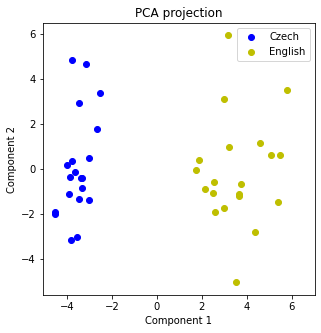

In [ ]:
plot_PCA_embeddings((cs_embeddings, en_embeddings), model, standardize=False, plot_segments=False)

Hmm.. Looks like we have the same "shape" but displaced. Which are the translation pairs?

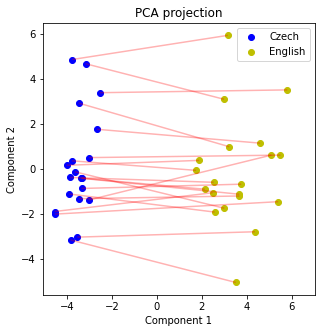

In [ ]:
plot_PCA_embeddings((cs_embeddings, en_embeddings), model, standardize=False, plot_segments=True)

Promising.. Let's standardize the czech embeddings and english ones separately

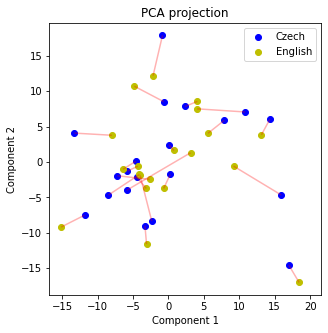

In [ ]:
plot_PCA_embeddings((cs_embeddings, en_embeddings), model, standardize=True, plot_segments=True)

Let's check a different representation of this, using a matrix containing the similarity metrics for cosine similarity and MSE. Both should look "diagonal"

(20, 20)


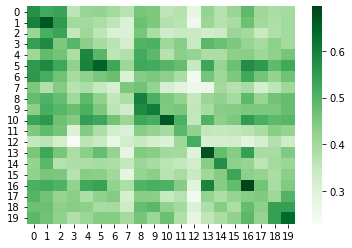

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 768])) that is different to the input size (torch.Size([20, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


(20, 20)


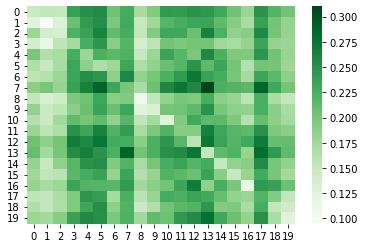

In [ ]:
plot_confusion_matrix((cs_embeddings, en_embeddings), model, standardize=False, loss_type="CosSim")
plot_confusion_matrix((cs_embeddings, en_embeddings), model, standardize=False, loss_type="MSE")

there's some "diagonality" there... But what happens after standardization?

(20, 20)


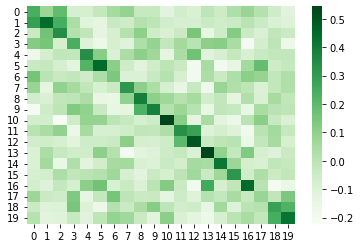

(20, 20)


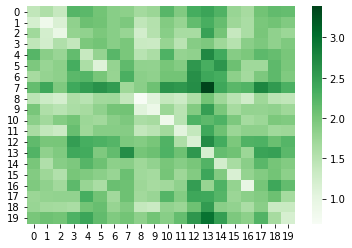

In [ ]:
plot_confusion_matrix((cs_embeddings, en_embeddings), model, standardize=True, loss_type="CosSim")
plot_confusion_matrix((cs_embeddings, en_embeddings), model, standardize=True, loss_type="MSE")

It looks like the Cosine Similarity matrix improves significantly after standardization. From this being diagonal, we can define an "accuracy" metric that, from this "confusion matrix", checks for each row whether the max (or min) value is the one of the diagonal.

In [ ]:
per_score_CosSim = get_performance_score((cs_tensor, en_tensor), model, standardize=False, loss_type="CosSim", pooling=True)
per_score_MSE = get_performance_score((cs_tensor, en_tensor), model, standardize=False, loss_type="MSE", pooling=True)

print(f"Performance metric with CosSim without standardization: {per_score_CosSim}. Performance metric with MSE without standardization: {per_score_MSE}")
# ((The warning may be quite important! I believe that broadcasting should work just fine in this case. But not 100% sure!!)) 

per_score_CosSim = get_performance_score((cs_tensor, en_tensor), model, standardize=True, loss_type="CosSim", pooling=True)
per_score_MSE = get_performance_score((cs_tensor, en_tensor), model, standardize=True, loss_type="MSE", pooling=True)

print(f"Performance metric with CosSim after standardization: {per_score_CosSim}. Performance metric with MSE after standardization: {per_score_MSE}")
# ((The warning may be quite important! I believe that broadcasting should work just fine in this case. But not 100% sure!!)) 

Performance metric with CosSim without standardization: 0.75. Performance metric with MSE without standardization: 0.5
Performance metric with CosSim after standardization: 0.9. Performance metric with MSE after standardization: 0.75


Nice! But we are only doing this on 20 samples... And, indeed, from samples not shuffled. Let's see what happens if we increase the number of this tensor

10


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 768])) that is different to the input size (torch.Size([10, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


20
50


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 768])) that is different to the input size (torch.Size([50, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


100


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 768])) that is different to the input size (torch.Size([100, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


150


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([1, 768])) that is different to the input size (torch.Size([150, 768])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


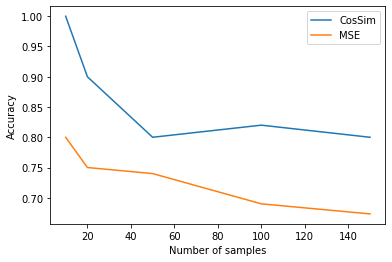

In [ ]:
#num_samples_list = [10, 20, 50, 100, 200, 500, 1000, 1500, 1982] #CUDA RUNS OUT OF MEMORY WITH AROUND 200 SAMPLES
num_samples_list = [10, 20, 50, 100, 150]
COSSIM_list = []
MSE_list =  []

try:
  del cs_tensor
  del en_tensor
  del cs_embedding
  del en_embedding
  torch.cuda.empty_cache() # Emptying cache
except: pass

for num_samples in num_samples_list:
    print(num_samples)
    cs_tensor = (get_mttt_iterable('cs', num_samples).take(num_samples).collect())
    en_tensor = (get_mttt_iterable('en', num_samples).take(num_samples).collect())

    per_score_CosSim = get_performance_score((cs_tensor, en_tensor), model, standardize=True, loss_type="CosSim", pooling=True)
    per_score_MSE = get_performance_score((cs_tensor, en_tensor), model, standardize=True, loss_type="MSE", pooling=True)

    COSSIM_list.append(per_score_CosSim)
    MSE_list.append(per_score_MSE)

plt.plot(num_samples_list, COSSIM_list, label="CosSim")
plt.plot(num_samples_list, MSE_list, label="MSE")
plt.legend()
plt.xlabel("Number of samples")
plt.ylabel("Accuracy")
plt.show()

Get the baselines for these metrics (already computed. Repeated here for readability):

In [ ]:
num_samples = 100
cs_tensor = (get_mttt_iterable('cs', num_samples).take(num_samples).collect())
en_tensor = (get_mttt_iterable('en', num_samples).take(num_samples).collect())

per_score_CosSim = get_performance_score((cs_tensor, en_tensor), model, standardize=True, loss_type="CosSim", pooling=True)
per_score_MSE = get_performance_score((cs_tensor, en_tensor), model, standardize=True, loss_type="MSE", pooling=True)

print(f"With standardization, the baseline metric is {per_score_CosSim:.2f} for CosSim and {per_score_MSE:.2f} for MSE")

per_score_CosSim = get_performance_score((cs_tensor, en_tensor), model, standardize=False, loss_type="CosSim", pooling=True)
per_score_MSE = get_performance_score((cs_tensor, en_tensor), model, standardize=False, loss_type="MSE", pooling=True)

print(f"Without standardization, the baseline metric is {per_score_CosSim:.2f} for CosSim and {per_score_MSE:.2f} for MSE")

With standardization, the baseline metric is 0.82 for CosSim and 0.69 for MSE
Without standardization, the baseline metric is 0.68 for CosSim and 0.55 for MSE


# Finetuning with an Adapter

### Define the bottleneck adapter class

In [ ]:
from torch import nn 

class BottleneckAdapterLayer(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.adapter_input_size = config.hidden_size
        self.adapter_latent_size = config.adapter_latent_size

        # Choose nonlinearity. In this case ReLU
        self.non_linearity = torch.relu

        self.residual = config.adapter_residual

        # down-project
        self.down_proj = nn.Linear(self.adapter_input_size, self.adapter_latent_size)
        # up-project
        self.up_proj = nn.Linear(self.adapter_latent_size, self.adapter_input_size)

        self.init_weights()

    def init_weights(self):
        """ Initialize the weights as a near-identity function """
        std = 0.01 # 0.02 # Standard deviation to use for initializing (should be small as we want a near-identity function)
        self.down_proj.weight.data.normal_(mean=0.0, std=std)
        self.down_proj.bias.data.zero_()
        self.up_proj.weight.data.normal_(mean=0.0, std=std)
        self.up_proj.bias.data.zero_()

    def forward(self, x):
        output = self.up_proj(self.non_linearity(self.down_proj(x)))
        if self.residual:
            output = x + output # residual connection (improves stability (?) I haven't tried without adding it)
        return output

### Define the AdapterBertModel class

In [ ]:
class AdapterBertIntermediate(BertIntermediate):
    def __init__(self, config, layer_index):
        super().__init__(config)
        self.add_adapter = layer_index in config.layers_to_adapt and config.add_intermediate_adapter 
        # Select layers containing adapters
        if self.add_adapter:
            self.intermediate_adapter = BottleneckAdapterLayer(config) # add adapter layers

    def forward(self, hidden_states):
        # extend the forward function to pass through the added adapter layers
        if self.add_adapter:
            hidden_states = self.intermediate_adapter(hidden_states)
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states

class AdapterBertOutput(BertOutput):
    def __init__(self, config, layer_index):
        super().__init__(config)
        self.add_adapter = layer_index in config.layers_to_adapt
        if self.add_adapter:
            self.output_adapter = BottleneckAdapterLayer(config)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        # extend the forward operation to pass through all the new layers
        if self.add_adapter:
            hidden_states = self.output_adapter(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

class AdapterBertLayer(BertLayer):
    def __init__(self, config, layer_index):
        super().__init__(config)        
        self.intermediate = AdapterBertIntermediate(config, layer_index)
        self.output = AdapterBertOutput(config, layer_index)

class AdapterBertEncoder(BertEncoder):
    def __init__(self, config):
        super().__init__(config)
        self.layer = nn.ModuleList([AdapterBertLayer(config, i) for i in range(config.num_hidden_layers)])

class AdapterBertModel(BertModel):
    def __init__(self, config):
        super().__init__(config)
        self.encoder = AdapterBertEncoder(config)
        self.freeze_original_params(config)

    def freeze_original_params(self, config):

        # The layer norms should be trainable, so require_grad = True. In my original implementation, this does not happen
        # these lines are supposed to help with that, but do not seem to solve the problem, and may contain errors.
        """
        for name, param in self.named_parameters():
          #print("Parameters name", name)
          #print(name[-16:], name[-14:], name[15])
          if name[-16:] != "LayerNorm.weight" and name[-14:] != "LayerNorm.bias" and name[15] not in config.layers_to_adapt:
            param.requires_grad = False
        """
        # a better approach would also be doing something like [p for n, p in model.named_parameters() if not any(nd in n for nd in ["LayerNorm"])]

        # Instead, do it the (wrong) old-way:
        for param in self.parameters():
            param.requires_grad = False

        for i in range(config.num_hidden_layers):
            if i in config.layers_to_adapt:
                for param in self.encoder.layer[i].intermediate.intermediate_adapter.parameters():
                    param.requires_grad = True # set require_grads to True for the adapter layers
                for param in self.encoder.layer[i].output.output_adapter.parameters():
                    param.requires_grad = True # set require_grads to True for the adapter layers

## Define the config for the adapters

In [ ]:
import copy
from transformers.data.processors import InputFeatures

class AdapterBertConfig(BertConfig):
    def __init__(self,
        layers_to_adapt = list(range(12)),
        #adapter_non_linearity = "gelu",
        adapter_latent_size = 64,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.layers_to_adapt = layers_to_adapt
        self.adapter_latent_size = adapter_latent_size
        #self.adapter_non_linearity = torch.relu #NOT JSON SERIALIZABLE! Implement it directly in the adapter
        self.adapter_residual = True
        self.add_intermediate_adapter = True

# RunConfig runs instanciates the configuration file
class RunConfig():
    def __init__(self):
        self.pretrained_transformer = 'bert-base-multilingual-cased'

        self.train_batch_size = 8
        self.learning_rate = 1e-7 #1e-18 #3e-5
        self.weight_decay = 0.0
        self.adam_epsilon = 1e-8
        self.max_grad_norm = 1.0
        self.num_train_epochs = 1 #10
        self.max_steps = -1
        self.warmup_steps = 0
        self.logging_steps = 10 #5000
        self.seed = 10
        self.device = "cuda"

        self.do_pooling = True

        #self.last_layer_dropout = 0.2
        #self.hidden_size = 100
 
        # # adapter params
        self.layers_to_adapt = list(range(8,12)) #list(range(8, 12))
        self.adapter_latent_size = 64
        #self.adapter_non_linearity = torch.relu #NOT JSON SERIALIZABLE!!
        # self.adapter_residual = True
        # self.add_intermediate_adapter = True

### Define loss function

In [ ]:
MSELoss = torch.nn.MSELoss(reduction="mean")
MSELoss_unreduced = torch.nn.MSELoss(reduction="none")
CosSim = torch.nn.CosineSimilarity()

def loss_function(output_cs, output_en, similarity="MSE", naive=False, standardize=True):

    # Idea of the loss function:
    # If naive = True, it maximizes the similarity between aligned sentences. But this could just make that the adapter makes all the embeddings to be close
    # If naive = False, it also takes into account non-aligned examples, by inverting the order of one of the aligned samples

    # If standardize, standardizes the embeddings separately for CS/EN.

    # Different similarity metrics can be used (CosSim, MSE)

    if standardize:
        means_cs = output_cs.mean(dim=0, keepdim=True)
        stds_cs = output_cs.std(dim=0, keepdim=True)
        output_cs = (output_cs - means_cs) / stds_cs

        means_en = output_en.mean(dim=0, keepdim=True)
        stds_en = output_en.std(dim=0, keepdim=True)
        output_en = (output_en - means_en) / stds_en

    if similarity == "MSE":
        if naive:
            mseloss = MSELoss(output_cs, output_en)
            loss = mseloss
        else:
            mseloss_positive = MSELoss(output_cs, output_en)
            mseloss_negative = MSELoss(output_cs, torch.flip(output_en, (0,))) # Change order of the array, so aligning non-translated sentences

            loss = mseloss_positive - mseloss_negative

    elif similarity == "CosSim":
        if naive:
            cossim = torch.mean(CosSim(output_cs, output_en))
            loss = -cossim
        else:
            cossim_positive = torch.mean(CosSim(output_cs, output_en))
            cossim_negative = torch.mean(CosSim(output_cs, torch.flip(output_en, (0,)))) # Change order of the array, so aligning non-translated sentences

            loss = -cossim_positive + cossim_negative

    return loss

### Define trainer

In [ ]:
import os
import random
from tqdm import tqdm, trange

from transformers import (
    WEIGHTS_NAME,
    AdamW,
    get_linear_schedule_with_warmup,
)

def set_seed(seed):
    # Set all seeds for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def prepare_optimizer_and_scheduler(model, t_total, c):
    # Add weight decay except for bias / LayerNorm.weight
    # (for regularization)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": c.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]

    #optimizer = AdamW(optimizer_grouped_parameters, lr=c.learning_rate, eps=c.adam_epsilon) # Recommended
    optimizer = torch.optim.SGD(optimizer_grouped_parameters, lr=c.learning_rate) # But let's stick to a simpler one to see what happens
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=c.warmup_steps, num_training_steps=t_total)

    return optimizer, scheduler


def train(train_dataset, eval_dataset, model, c, len_dataloader, tensors_plot, naive_loss=False, show_pca_plots=False, show_confusion_matrix=False, 
          eval_tensor="none", standardize_loss=True, pooling=True, check_gradients=False, loss_similarity="MSE", reset_pca=True):
    """ Train the model """

    if eval_tensor == "none": 
      pprint("WARNING: EVAL TENSOR SET TO TENSORS PLOT")
      eval_tensor = tensors_plot
    
    train_dataloader = train_dataset

    if c.max_steps > 0:
        t_total = c.max_steps
        c.num_train_epochs = c.max_steps // len_dataloader + 1
    else:
        t_total = len_dataloader * c.num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    optimizer, scheduler = prepare_optimizer_and_scheduler(model, t_total, c)
    
    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0

    tr_loss, logging_loss = 0.0, 0.0
    model.zero_grad()

    train_iterator = trange(epochs_trained, int(c.num_train_epochs), desc="Epoch", disable=False)

    set_seed(c.seed)  # for reproductibility, we always train with the same parameter initialization

    LOGS = {}

    if check_gradients:
      GRADIENTS = {}

    #print("Memory allocated before batch iteration", torch.cuda.memory_allocated(device=None))
    for _ in train_iterator:
        #epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=False)
        #for step, batch in enumerate(epoch_iterator):
        for step, batch in enumerate(train_dataloader):
            # Skip past any already trained steps if resuming training
            if step==0:
              if show_pca_plots:
                pca = plot_PCA_embeddings(tensors_plot, model, standardize=False, return_pca = True, title=f"Step {step}", save=f"PCA_{step//10}")
                pca_st = plot_PCA_embeddings(tensors_plot, model, standardize=True, return_pca = True, title=f"Step {step}", save=f"PCA_st_{step//10}")
              if show_confusion_matrix:
                plot_confusion_matrix(tensors_plot, model, standardize=True, loss_type = "MSE", title=f"Step {step}", save=f"CM_MSE_{step//10}")
                plot_confusion_matrix(tensors_plot, model, standardize=True, loss_type = "CosSim", title=f"Step {step}" , save=f"CM_CosSim_{step//10}")

              #print("Performance score:", get_performance_score(tensors_plot, model, standardize=True, loss_type="cossim"))
            elif step%10 == 0: 
              #print("Step", step)
              if show_pca_plots:
                if reset_pca:
                  plot_PCA_embeddings(tensors_plot, model, standardize=False, trained_pca = pca, title=f"Step {step}", save=f"PCA_{step//10}")
                  plot_PCA_embeddings(tensors_plot, model, standardize=True, trained_pca = pca_st, title=f"Step {step}", save=f"PCA_st_{step//10}")
                else:
                  plot_PCA_embeddings(tensors_plot, model, standardize=False, title=f"Step {step}", save=f"PCA_{step//10}")
                  plot_PCA_embeddings(tensors_plot, model, standardize=True,  title=f"Step {step}", save=f"PCA_st_{step//10}")

              if show_confusion_matrix:
                plot_confusion_matrix(tensors_plot, model, standardize=True, loss_type = "MSE", title=f"Step {step}", save=f"CM__MSE_{step//10}")
                plot_confusion_matrix(tensors_plot, model, standardize=True, loss_type = "CosSim", title=f"Step {step}", save=f"CM_CosSim_{step//10}")
              #print("Performance score:", get_performance_score(tensors_plot, model, standardize=True, loss_type="cossim"))
              
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            """
            if check_gradients:
              INITIAL_GRADIENTS = {}
              for name, param in model.named_parameters():
                INITIAL_GRADIENTS[name] = param.grad
            """

            model.train() 
            #print("Memory allocated after model.train()", torch.cuda.memory_allocated(device=None))

            cs_tensor = list(map(lambda x: x["translation"]["cs"], batch))
            en_tensor = list(map(lambda x: x["translation"]["en"], batch))

            cs_tensor = tokenizer(cs_tensor, padding="max_length", truncation=True, return_tensors="pt").to(device)
            en_tensor = tokenizer(en_tensor, padding="max_length", truncation=True, return_tensors="pt").to(device)

            if pooling:
                output_cs = model(**cs_tensor)
                output_en = model(**en_tensor)

                output_cs = mean_pooling(output_cs, cs_tensor['attention_mask'])
                output_en = mean_pooling(output_en, en_tensor['attention_mask'])

            else:
              output_cs = model(**cs_tensor)[0]
              output_en = model(**en_tensor)[0]

            loss = loss_function(output_cs, output_en, similarity=loss_similarity, naive=naive_loss, standardize=standardize_loss)
            #loss = - loss_function(output_cs, output_en, similarity="MSE", naive=naive_loss, standardize=True) 
            # Something went somehow wrong, so I just changed the loss sign to see what happens

            # parameter updates
            #print("Memory allocated before loss backward", torch.cuda.memory_allocated(device=None))
            loss.backward()
            #print("Memory allocated after loss backward", torch.cuda.memory_allocated(device=None))

            if check_gradients:
              for name, param in model.named_parameters():
                if param.requires_grad: 
                # FORGOT THE IF_REQUIRES GRAD!! If not, returning None (obviously...)
                    #print("PARAM GRADIENTS", param.grad)
                    try: GRADIENTS[name].append(torch.norm(param.grad).cpu().numpy())
                    except: GRADIENTS[name] = [torch.norm(param.grad).cpu().numpy()]
                    #try: GRADIENTS[name].append(param.grad - INITIAL_GRADIENTS[name])
                    #else: GRADIENTS[name] = param.grad

            tr_loss += loss.item()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), c.max_grad_norm) # Clipping grad norm. Not using to make it simpler

            optimizer.step()
            scheduler.step()  # Update learning rate schedule
            model.zero_grad() # zeroing gradients afer update

            global_step += 1

            if c.logging_steps > 0 and global_step % c.logging_steps == 0:
                #print("Global step: " + str(global_step))
                logs = {}
                results = evaluate(eval_tensor, model)
                for key, value in results.items():
                    eval_key = "eval_{}".format(key)
                    logs[eval_key] = value

                loss_scalar = (tr_loss - logging_loss) / c.logging_steps
                #learning_rate_scalar = scheduler.get_lr()[0]
                learning_rate_scalar = scheduler.get_last_lr()[0]
                logs["learning_rate"] = learning_rate_scalar
                logs["step"] = global_step
                logs["loss"] = loss_scalar
                logging_loss = tr_loss

                for key, value in logs.items():
                    try: LOGS[key].append(value)
                    except: LOGS[key] = [value]
                
            if c.max_steps > 0 and global_step > c.max_steps:
                epoch_iterator.close()
                break
        
        if (c.max_steps > 0 and global_step > c.max_steps):
            train_iterator.close()
            break
    """
    if check_gradients: 
      for key in GRADIENTS.keys():
          plt.plot(GRADIENTS[key], label = key)
          plt.legend()
      plt.show()
    """

    if check_gradients:
      return model, GRADIENTS, LOGS

    return LOGS

### Evaluate function

In [ ]:
def evaluate(eval_tensor, model):
    results = {}
    results["accuracy cossim"] = get_performance_score(eval_tensor, model, standardize=True, loss_type="CosSim")
    results["accuracy MSE"] = get_performance_score(eval_tensor, model, standardize=True, loss_type="MSE")

    results["accuracy cossim nostandard"] = get_performance_score(eval_tensor, model, standardize=False, loss_type="CosSim")
    results["accuracy MSE nostandard"] = get_performance_score(eval_tensor, model, standardize=False, loss_type="MSE")

    return results

## Starting the fun

In [ ]:
# Define number of samples in dataset (ugly and unrequired! But it works and I use it)
train_samples = 7270695 # number of training samples in the dataset
val_samples = 2983 # number of val samples in the dataset

# Define batch size and total number of samples from the subset
batch_size = 8
take_number = 8000  # Ugly implementation. This would basically set the number of training iterations (take_number // batch_size)

NON_ADAPTER_TRAINING = False # USE FOR DEBUGGING PURPOSES (train the whole network, without adapters)

device = torch.device("cuda")
model_label = "bert-base-multilingual-cased"
#print("Memory allocated before deleting model", torch.cuda.memory_allocated(device=None))
try: del model
except: pass
#print("Memory allocated after deleting model", torch.cuda.memory_allocated(device=None))
torch.cuda.empty_cache()
#print("Memory allocated after empty cache", torch.cuda.memory_allocated(device=None))

cs_tensor = (get_mttt_iterable('cs', 100).take(20).collect())
en_tensor = (get_mttt_iterable('en', 100).take(20).collect())

# Create a tensor used for the evaluation
eval_tensor = get_wmt19_hf_iterable(split="validation").shuffle(val_samples).take(100).collect()
eval_cs = list(map(lambda x: x["translation"]["cs"], eval_tensor))
eval_en = list(map(lambda x: x["translation"]["en"], eval_tensor))
eval_tensor = (eval_cs, eval_en)

c = RunConfig()

if NON_ADAPTER_TRAINING:
  tokenizer = BertTokenizer.from_pretrained(model_label)
  config = BertConfig.from_pretrained(model_label)
  model = BertModel.from_pretrained(model_label).to(device)

else:
  if model_label == "bert-base-multilingual-uncased" or model_label == "bert-base-multilingual-cased" or model_label == "bert-large-uncased":
    tokenizer = BertTokenizer.from_pretrained(model_label)
    #config = BottleneckAdapterBertConfig.from_pretrained(model_label)
    config = AdapterBertConfig.from_pretrained(model_label)
    config.layers_to_adapt = c.layers_to_adapt
    config.adapter_latent_size = c.adapter_latent_size
    #config.adapter_non_linearity = c.adapter_non_linearity  #IMPLEMENT THIS DIRECTLY ON THE ADAPTER NETWORK

    model = AdapterBertModel.from_pretrained(model_label, config=config).to(device)

train_data = get_wmt19_hf_iterable(split="train").take(take_number).shuffle(train_samples).batched(batch_size)
eval_data = get_wmt19_hf_iterable(split="validation").shuffle(val_samples).batched(batch_size)

# Set seed
set_seed(c.seed)

# IF CHECK_GRADIENTS, RETURNS THE MDOEL, GRADIENTS AND LOGS. ELSE, ONLY LOGS
trained_model, gradients, logs = train(train_data, eval_data, model, c, train_samples, (cs_tensor, en_tensor), show_confusion_matrix=False, 
              eval_tensor = eval_tensor, naive_loss=True, standardize_loss=False, check_gradients = True, loss_similarity="MSE")
#             eval_tensor = eval_tensor, naive_loss=False, standardize_loss=True, check_gradients = True, loss_similarity="MSE")

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing AdapterBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing AdapterBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AdapterBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AdapterBertModel were not initialized from the model checkpoint at bert-base-multilingual-cased and are new

## Plot the evolution of the gradient norms

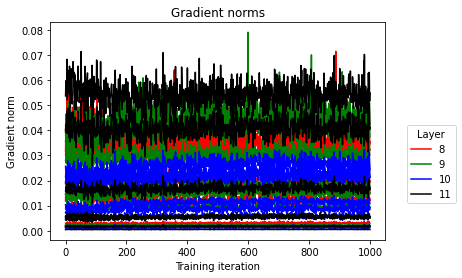

In [ ]:
color_dict = {8: "r", 9: "g", 10 : "b", 11 : "k", 'embeddings.LayerNorm.weight' : "y", 'embeddings.LayerNorm.bias' : "pink"}

for key in gradients.keys():
    try:
      try:
        n_layer = int(key[14:16])
      except:
        n_layer = int(key[14])
    except:
      n_layer = key

    c = color_dict[n_layer]

    plt.plot(gradients[key], c=c, label = n_layer)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    #plt.plot(gradients[key], c=c, label = key)
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 0.55), title="Layer")
    plt.title("Gradient norms")
    plt.xlabel(("Training iteration"))
    plt.ylabel("Gradient norm")
plt.show()

In [ ]:
print(logs)

{'eval_accuracy cossim': [0.77, 0.82, 0.74, 0.8, 0.72, 0.75, 0.77, 0.79, 0.82, 0.79, 0.74, 0.77, 0.78, 0.85, 0.81, 0.8, 0.82, 0.85, 0.78, 0.78, 0.76, 0.8, 0.78, 0.78, 0.75, 0.8, 0.77, 0.77, 0.8, 0.77, 0.78, 0.81, 0.8, 0.82, 0.84, 0.81, 0.82, 0.77, 0.78, 0.81, 0.77, 0.85, 0.68, 0.82, 0.77, 0.77, 0.77, 0.77, 0.76, 0.77, 0.77, 0.8, 0.75, 0.73, 0.77, 0.73, 0.86, 0.82, 0.8, 0.79, 0.76, 0.78, 0.79, 0.78, 0.89, 0.8, 0.75, 0.8, 0.82, 0.77, 0.8, 0.81, 0.77, 0.84, 0.78, 0.75, 0.77, 0.78, 0.76, 0.74, 0.79, 0.84, 0.8, 0.76, 0.78, 0.81, 0.79, 0.83, 0.76, 0.72, 0.82, 0.81, 0.73, 0.85, 0.74, 0.85, 0.83, 0.82, 0.77, 0.72], 'eval_accuracy MSE': [0.64, 0.69, 0.62, 0.68, 0.61, 0.67, 0.57, 0.68, 0.63, 0.61, 0.64, 0.62, 0.59, 0.66, 0.58, 0.66, 0.64, 0.58, 0.62, 0.67, 0.67, 0.69, 0.65, 0.63, 0.66, 0.69, 0.63, 0.58, 0.61, 0.63, 0.64, 0.6, 0.65, 0.56, 0.57, 0.61, 0.61, 0.6, 0.68, 0.63, 0.62, 0.59, 0.56, 0.65, 0.6, 0.62, 0.64, 0.6, 0.62, 0.56, 0.58, 0.66, 0.68, 0.6, 0.68, 0.61, 0.65, 0.65, 0.65, 0.58, 0.57, 0.

## Plot the accuracies evolution

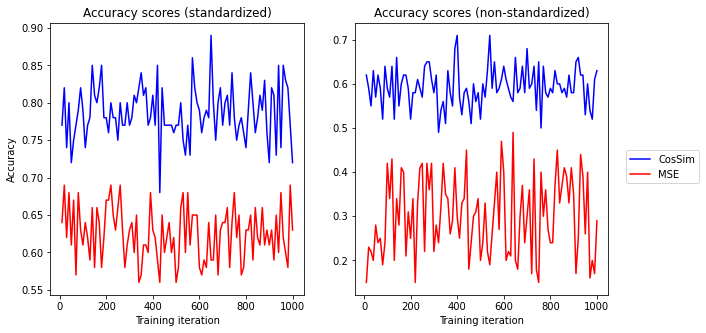

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(logs["step"], logs["eval_accuracy cossim"], c="b", label="CosSim")
ax[0].plot(logs["step"], logs["eval_accuracy MSE"], c="r", label="MSE")
#ax[0].legend()
ax[0].set_title("Accuracy scores (standardized)")
ax[0].set_xlabel("Training iteration")
ax[0].set_ylabel("Accuracy")

ax[1].plot(logs["step"], logs["eval_accuracy cossim nostandard"], c="b", label="CosSim")
ax[1].plot(logs["step"], logs["eval_accuracy MSE nostandard"], c="r", label="MSE")
ax[1].legend()
ax[1].legend(bbox_to_anchor=(1.05, 0.55))
ax[1].set_title("Accuracy scores (non-standardized)")
ax[1].set_xlabel("Training iteration")
#ax.set_ylabel("Accuracy")

plt.show()

## Plot the loss evolution

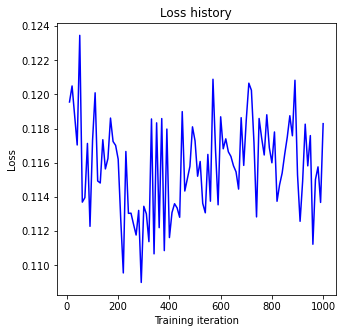

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(logs["step"], logs["loss"], c="b")
#ax[0].legend()
ax.set_title("Loss history")
ax.set_xlabel("Training iteration")
ax.set_ylabel("Loss")
plt.show()

## Print number of trainable parameters

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total number of parameters", pytorch_total_params)
print("Number of trainable parameters", pytorch_trainable_params)

print(f"Trainable parameters fraction {100*pytorch_trainable_params / pytorch_total_params:.2f}%")

Total number of parameters 178646528
Number of trainable parameters 793088
Trainable parameters fraction 0.44%


## Plot PCA evolution

In [ ]:
batch_size = 8
take_number = 8000  # Ugly implementation. This would basically set the number of training iterations (take_number // batch_size)

NON_ADAPTER_TRAINING = False # USE FOR DEBUGGING PURPOSES (train the whole network, without adapters)

device = torch.device("cuda")
model_label = "bert-base-multilingual-cased"
#print("Memory allocated before deleting model", torch.cuda.memory_allocated(device=None))
try: del model
except: pass
#print("Memory allocated after deleting model", torch.cuda.memory_allocated(device=None))
torch.cuda.empty_cache()
#print("Memory allocated after empty cache", torch.cuda.memory_allocated(device=None))

cs_tensor = (get_mttt_iterable('cs', 100).take(20).collect())
en_tensor = (get_mttt_iterable('en', 100).take(20).collect())

# Create a tensor used for the evaluation
eval_tensor = get_wmt19_hf_iterable(split="validation").shuffle(val_samples).take(100).collect()
eval_cs = list(map(lambda x: x["translation"]["cs"], eval_tensor))
eval_en = list(map(lambda x: x["translation"]["en"], eval_tensor))
eval_tensor = (eval_cs, eval_en)

c = RunConfig()

if NON_ADAPTER_TRAINING:
  tokenizer = BertTokenizer.from_pretrained(model_label)
  config = BertConfig.from_pretrained(model_label)
  model = BertModel.from_pretrained(model_label).to(device)

else:
  if model_label == "bert-base-multilingual-uncased" or model_label == "bert-base-multilingual-cased" or model_label == "bert-large-uncased":
    tokenizer = BertTokenizer.from_pretrained(model_label)
    #config = BottleneckAdapterBertConfig.from_pretrained(model_label)
    config = AdapterBertConfig.from_pretrained(model_label)
    config.layers_to_adapt = c.layers_to_adapt
    config.adapter_latent_size = c.adapter_latent_size
    #config.adapter_non_linearity = c.adapter_non_linearity  #IMPLEMENT THIS DIRECTLY ON THE ADAPTER NETWORK

    model = AdapterBertModel.from_pretrained(model_label, config=config).to(device)

train_data = get_wmt19_hf_iterable(split="train").take(take_number).shuffle(train_samples).batched(batch_size)
eval_data = get_wmt19_hf_iterable(split="validation").shuffle(val_samples).batched(batch_size)

# Set seed
set_seed(c.seed)

trained_model, gradients, logs = train(train_data, eval_data, model, c, train_samples, (cs_tensor, en_tensor), show_pca_plots=True, show_confusion_matrix=True,
              eval_tensor = eval_tensor, naive_loss=False, standardize_loss=True, check_gradients = True, loss_similarity="CosSim", reset_pca=False) 
             #eval_tensor = eval_tensor, naive_loss=False, standardize_loss=True, check_gradients = True, loss_similarity="MSE")

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(logs["step"], logs["eval_accuracy cossim"], c="b", label="CosSim")
ax[0].plot(logs["step"], logs["eval_accuracy MSE"], c="r", label="MSE")
#ax[0].legend()
ax[0].set_title("Accuracy scores (standardized)")
ax[0].set_xlabel("Training iteration")
ax[0].set_ylabel("Accuracy")

ax[1].plot(logs["step"], logs["eval_accuracy cossim nostandard"], c="b", label="CosSim")
ax[1].plot(logs["step"], logs["eval_accuracy MSE nostandard"], c="r", label="MSE")
ax[1].legend()
ax[1].legend(bbox_to_anchor=(1.05, 0.55))
ax[1].set_title("Accuracy scores (non-standardized)")
ax[1].set_xlabel("Training iteration")
#ax.set_ylabel("Accuracy")

plt.show()